In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os 
import pandas as pd 
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Creation of the pytorch dataset

In [3]:
#Useful functions

def import_matfiles(path):
    list_mat_ex = os.listdir(path2)
    #list_mat_file contains all interessant files for our research
    list_mat_ex.remove('readme.txt')
    #list_mat_file contains all interessant files for our research
    label = list_mat_ex[-1]
    print(label)
    list_mat_ex.pop(-1)
    return list_mat_ex, label
    
def find_max_shape(datas, freq = None):
    #shape of data in datas (freq, nb channel, activity)
    if freq == None:
        max_ = datas[0].shape[2]
        for data in datas[1:]:
            act_shape = data.shape[2]
            if act_shape > max_ :
                max_ = act_shape
    else :
        #hape of data in datas (nb channel, activity)
        max_ = datas[0].shape[1]
        for data in datas[1:]:
            act_shape = data.shape[1]
            if act_shape > max_ :
                max_ = act_shape
    return max_  

def x_shaper(x):
    """
    Arg: x as when it outcome from the dataset
    return: x as we wants tensor with (freq, nb_channel, activity)
    """
    x = x.transpose((2, 0, 1))
    return torch.from_numpy(x).type(torch.float32)

def datas_shaper(datas):
    res = []
    for data in datas:
        print(data.shape)
        res.append(x_shaper(data))
    return res 

def padd(datas, freq = None):
    #shape of data in datas (freq, nb channel activity)
    max_shape = find_max_shape(datas, freq =freq)
    res = []
    if freq == None :
        for data in datas:
            aux = torch.zeros((data.shape[0], data.shape[1], max_shape))
            if data.shape[2] < max_shape:
                add_shape = max_shape - data.shape[2]
                for freq in range(data.shape[0]):
                    pad_tensor = torch.zeros((data.shape[1], add_shape))
                    aux[freq, :, :] = torch.cat((data[freq, :, :], pad_tensor), dim=1)
                    aux = aux.type(torch.float32)
                res.append(aux)
            else :
                res.append(data.type(torch.float32))
    else :
        for data in datas:
            aux = torch.zeros((data.shape[0], max_shape))
            if data.shape[1] < max_shape:
                add_shape = max_shape - data.shape[1]
                pad_tensor = torch.zeros((data.shape[0], add_shape))
                aux = torch.cat((data, pad_tensor), dim=1)
                aux = aux.type(torch.float32)
                res.append(aux)
            else :
                res.append(data.type(torch.float32))
    return res

def normalize(x, freq = None):
    if freq == None:
        for frequencies in range(x.shape[0]):
            mean_ = torch.mean(x[frequencies, :, :], 1).reshape(-1, 1)
            std_ = torch.std(x[frequencies, : ,: ], 1).reshape(-1, 1)
            x[frequencies, :, :] = (x[frequencies, :, :] - mean_) / std_
            return x
    else :
        mean_ = torch.mean(x[freq, :, :], 1).reshape(-1, 1)
        std_ = torch.std(x[freq, : ,: ], 1).reshape(-1, 1)
        x[freq, :, :] = (x[freq, :, :] - mean_) / std_
        return x[freq, :, :]

In [66]:
#version to improve in a near future..
class SignalDataset(Dataset):
    def __init__(self, path, signals, subject_number, experiment_number, labels, smoothing_method, freq = None):
        """
        Args: 
            path: path to folder with all the .mat files of the dataset
            signals: feature that we want to extract
            subject_number: subject of the experimenr
            epxeriment_number: number of the experiment, like 0 week 1 week or 2 week 
            (MAYBE I MISUNDERSTOOD THIS PART READ AGAIN DATASET DETAILS)
            labels: labels list
            smoothing method: movingAve or LDS
            freq: 0, 1, 2, 3 or 4 for just specific one and None if you want them all
        """
        list_file, _ = import_matfiles(path)
        #selection of interesting files that means the one related to the subject
        list_sub_file = []
        for file in list_file:
            num = file.split('_')[0]
            if int(num) == subject_number: 
                list_sub_file.append(file)
             
        working_file = list_sub_file[experiment_number]
        
        dic = loadmat(path + '\\' + working_file) 
        if smoothing_method == 'movingAve':
            smooth = signals.lower() + '_movingAve'
        elif smoothing_method == 'LDS':
            smooth = signals.lower() + '_LDS'
        else :
            raise ValueError('Please select a good smoothing method: movingAve or LDS')
        
        #maybe a list is not the best tool to store it
        datas = []
        for k in range(15):
            sig = dic[smooth + str(k+1)]
            sig = x_shaper(sig)
            sig = normalize(sig, freq = freq) #change the freq if needed!!!!!!!!!!!!
            datas.append(sig)
            
        
        datas = padd(datas, freq = freq) #everything is happening in this function, the changement from Long to Float
                                    #and the slicing for the frequency we want

        labels = labels.reshape(-1, )
        labels = labels + 1 #sliding to use CrossEntropy Pytorch function
        labels = torch.from_numpy(labels)
                                  
                                  
        self.datas = datas
        self.labels = labels
    
    def __len__(self):
        return len(self.datas)
    
    def __getitem__(self, idx):
        return self.datas[idx], self.labels[idx].item()

In [5]:
#get labels 
path2 = r'C:\Users\harol\UsefulCode\CP_DSAI\Project\Dataset\SEED\ExtractedFeatures'
l, label_ = import_matfiles(path2)
labels = loadmat(path2 + '\\' + label_)['label']

label.mat


In [6]:
path = r'C:\Users\harol\UsefulCode\CP_DSAI\Project\Dataset\SEED\ExtractedFeatures'
signals = 'de'
subject_number = 4
experiment_number = 0
labels = labels
smoothing_method = 'movingAve'
dataset = SignalDataset(path, signals, subject_number, experiment_number, labels, smoothing_method, freq = 0)
train_dataset, test_dataset = random_split(dataset, [9, 6])
print(len(dataset))
print(len(train_dataset), len(test_dataset))

label.mat
15
9 6


In [7]:
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [8]:
samp = next(iter(train_loader))
data, lab = samp
print(data.dtype)
print(data.shape)
print(lab)

torch.float32
torch.Size([1, 62, 265])
tensor([1])


## Preliminaries

In [9]:
#creation of the adjency matrix

channel = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 
                'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6','FT8','T7','C5','C3','C1',
                'CZ','C2','C4','C6', 'T8','TP7','CP5','CP3','CP1','CPZ','CP2','CP4','CP6','TP8','P7',
                'P5','P3','P1','PZ','P2','P4','P6','P8','PO7','PO5','PO3','POZ','PO4','PO6','PO8','CB1',
                'O1','OZ','O2','CB2']
idx = np.arange(62)
df_channel = pd.DataFrame({'idx': idx, 'channel': channel })

#initialization of the adjency matrix
feature_number = 62
W = np.zeros((5, feature_number, feature_number))
for freq in range(5):
    #I don't see other way than initialiazing W manually
    #was done accodingly to the EEG channel map and order, hope to don't have make mistake
    #FP1
    W[freq, 0, 1] = 1
    W[freq, 0, 3] = 1
    #FPZ
    W[freq, 1, 0] = 1
    W[freq, 1, 2] = 1
    #FP2
    W[freq, 2, 1] = 1
    W[freq, 2, 4] = 1
    #AF3
    W[freq, 3, 8] = 1
    W[freq, 3, 7] = 1
    W[freq, 3, 6] = 1
    W[freq, 3, 0] = 1
    #AF4
    W[freq, 4, 2] = 1
    W[freq, 4, 10] = 1
    W[freq, 4, 11] = 1
    W[freq, 4, 12] = 1
    #F7
    W[freq, 5, 6] = 1
    W[freq, 5, 14] = 1
    #F5
    W[freq, 6, 3] = 1
    W[freq, 6, 5] = 1
    W[freq, 6, 15] = 1
    W[freq, 6, 7] = 1
    #F3
    W[freq, 7, 3] = 1
    W[freq, 7, 8] = 1
    W[freq, 7, 16] = 1
    #F1
    W[freq, 8, 9] = 1
    W[freq, 8, 17] = 1
    #FZ
    W[freq, 9, 10] = 1
    W[freq, 9, 18] = 1
    #F2
    W[freq, 10, 11] = 1
    W[freq, 10, 19] = 1
    #F4
    W[freq, 11, 12] = 1
    W[freq, 11, 20] = 1
    #F6 
    W[freq, 12, 13] = 1
    W[freq, 12, 21] = 1
    #F8
    W[freq, 13, 22] = 1
    #FT7
    W[freq, 14, 15] = 1
    W[freq, 14, 23] = 1
    #FC5 to TP8
    for k in range(15, 41): #till TP8 (number 40) we have two new neigbors: on the right and under +1 and +9 (nine electrodes per line)
        if k == 22 or k == 31 or k == 40 :
            W[freq, k, k+9] = 1
        else:
            W[freq, k, k+1] = 1
            W[freq, k, k+9] = 1
    #P7
    W[freq, 41, 42] = 1
    W[freq, 41, 50] = 1
    #P5
    W[freq, 42, 43] = 1
    W[freq, 42, 51] = 1
    #P3
    W[freq, 43, 44] = 1
    #P1
    W[freq, 44, 45] = 1
    W[freq, 44, 52] = 1
    #PZ
    W[freq, 45, 46] = 1
    W[freq, 45, 53] = 1
    #P2
    W[freq, 46, 47] = 1
    W[freq, 46, 54] = 1
    #P4
    W[freq, 47, 48] = 1
    #P6
    W[freq, 48, 49] = 1
    W[freq, 48, 55] = 1
    #P8
    W[freq, 49, 56] = 1
    #PO7
    W[freq, 50, 51] = 1
    W[freq, 50, 57] = 1
    #PO5
    W[freq, 51, 52] = 1
    W[freq, 50, 57] = 1
    #PO3
    W[freq, 52, 53] = 1
    W[freq, 52, 58] = 1
    #POZ
    W[freq, 53, 54] = 1
    W[freq, 53, 59] = 1
    #PO4
    W[freq, 54, 55] = 1
    W[freq, 54, 60] = 1
    #PO6
    W[freq, 55, 56] = 1
    W[freq, 55, 61] = 1
    #PO8
    W[freq, 56, 61] = 1
    #CB1
    W[freq, 57, 58] = 1
    #O1
    W[freq, 58, 59] = 1
    #OZ
    W[freq, 59, 60] = 1
    #O2
    W[freq, 60, 61] = 1

for freq in range(5):
    for i in range(feature_number):
        for j in range(i, feature_number):
            if W[freq, j, i] == 0:
                W[freq, j, i] = W[freq, i, j]
    W[freq, :, :] = W[freq, :, :] - np.eye(feature_number)

#for some training stability reasons we initialized the diagonal of W with 1
for freq in range(5):
    W[freq, :, :] = W[freq, :, :] + np.eye(W.shape[1], dtype=int)
W = torch.from_numpy(W).type(torch.float32)
print(W.shape)
print(W[0])

torch.Size([5, 62, 62])
tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])


In [10]:
#functions use inside the model

##### CREATE A CLASS IF IMPLEMENTATION FINISHED ####
#more elegant


def D_matrix(W, multifreq = True):
    if multifreq:
        for freq in range(W.shape[0]):
            D[freq, :, :] = torch.diag(W[freq].sum(dim=-1))
    else :
        D = torch.diag(W.sum(dim=-1))
    return D

def laplacian(W, multifreq = True): #here we calculate the non noramlized Laplacian matrix of the graph
    #multifreq means if we get the five frequencies in one or not
    L = D_matrix(W, multifreq = multifreq) - W
    L = L.type(torch.float32)
    return L


def x_shaper(x):
    """
    Arg: x as when it outcome from the dataset
    return: x as we wants tensor with (freq, nb_channel, activity)
    """
    x = x.transpose((2, 0, 1))
    return torch.from_numpy(x)


def cheby_laplacian(L, x, theta, multifreq = True):
    """
    Arg: Laplacian matrix, x the extracted signal, theta chebyshev coefficients, K the order of the polynom
    
    we suppose that x was transform to a tensor and that its shape was made as (freq, nb channel, activity)
    
    Return: the sum thetak*Tk(L)*x
    """
 
    y = torch.zeros_like(x) 
    K = theta.shape[0] - 1
    
    if multifreq :
        L_tilde = torch.zeros_like(L) 
        for freq in range(L.shape[0]):
            #chebyshev polynoms is a basis in the domain [-1, 1]
            with torch.no_grad():
                eigenvalues, eigenvectors = torch.linalg.eig(L[freq, :, :])
                eigenvalues = eigenvalues.real #since L is symmetric real L is diagonalizable in the real space
                max_lambda = torch.max(eigenvalues).item() 
            L_tilde[freq, :, :] = ((2*L[freq, :, :]) / max_lambda) - torch.eye(L.shape[1])
            
            x_ = x[freq, :, :]
            L_ = L_tilde[freq, :, :]
            L_.type(torch.float32)

            x0_hat = x_
            x1_hat = torch.matmul(L_, x_)

            if K == 0:
                y[freq, :, :] = x0_hat*theta[0]
            if K == 1:
                y[freq, :, :] = x1_hat*theta[1] + x0_hat*theta[0]
            else:
                y[freq, :, :] = x0_hat*theta[0] + x1_hat*theta[1] 
                for k in range(2, K):
                    x2_hat = 2*torch.matmul(L_, x1_hat) - x0_hat
                    y[freq, :, :] += x2_hat*theta[k]
                    x1_hat = x2_hat
                    x0_hat = x1_hat
    else :
        with torch.no_grad():
            eigenvalues, eigenvectors = torch.linalg.eig(L)
            eigenvalues = eigenvalues.real #since L is symmetric real L is diagonalizable in the real space
            max_lambda = torch.max(eigenvalues).item() 
            
        #rescaling
        L_tilde = ((2*L) / max_lambda) - torch.eye(L.shape[0])
        
        #intialization of variables
        x_ = x
        L_ = L_tilde
        
        L_ = L_.type(torch.float32)

        x0_hat = x_
        x1_hat = torch.matmul(L_, x_)
        
        #calculus of Chebyshev polynoms
        if K == 0:
            y = x0_hat*theta[0]
        elif K == 1:
            y = x1_hat*theta[1] + x0_hat*theta[0]
        else:
            y = x0_hat*theta[0] + x1_hat*theta[1] 
            for k in range(2, K):
                x2_hat = 2*torch.matmul(L_, x1_hat) - x0_hat
                y += x2_hat*theta[k]
                x1_hat = x2_hat
                x0_hat = x1_hat              
    return y

## Creation of the model 

In [11]:
import torch.nn as nn
import torch.nn.functional as F

### First model

Note: For the moment works on only one frequency. Intialization of theta can impact on the speed of convergence of the model.

In [12]:
class DGCNLayerCheb(nn.Module):
    def __init__(self, W, K):
        super().__init__()
        self.W = nn.Parameter(W)
        self.theta = nn.Parameter(torch.FloatTensor(K, 1))
        self.theta = nn.init.uniform_(self.theta, 0, 10)
        
    def forward(self, x):
        L = laplacian(self.W, multifreq = False)
        X = cheby_laplacian(L, x, self.theta, multifreq = False)
        return X
    
class DGCN_Cheb(nn.Module):
    def __init__(self, W, K, input_size, hidden_size, output_size):
        super().__init__()
        self.GCNLayer1 = DGCNLayerCheb(W, K)
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.3)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.GCNLayer1(x) 
        x = F.relu(x)
        x = x.view(-1, self.input_size)
        x = self.l1(x)
        x = self.tanh(x)
        x = self.dropout(x)
        x = self.l2(x)
        return self.tanh(x)

In [13]:
#matrix we will work with
W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency

#model
model = DGCN_Cheb(W_, 15, 62*265, 50, 3).to(device)
print('------------- Model architecture ---------------')
print(model.parameters)
print(' ')
print('------------- Model parameters ---------------')
for param in model.parameters():
    print(type(param.data), param.size())
    
#hyperparameters, loss functions and optimizer

learning_rate = 0.0001
alpha = 1e-6 #regularization parameter
num_epochs = 1000

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 

------------- Model architecture ---------------
<bound method Module.parameters of DGCN_Cheb(
  (GCNLayer1): DGCNLayerCheb()
  (l1): Linear(in_features=16430, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)>
 
------------- Model parameters ---------------
<class 'torch.Tensor'> torch.Size([62, 62])
<class 'torch.Tensor'> torch.Size([15, 1])
<class 'torch.Tensor'> torch.Size([50, 16430])
<class 'torch.Tensor'> torch.Size([50])
<class 'torch.Tensor'> torch.Size([3, 50])
<class 'torch.Tensor'> torch.Size([3])


In [23]:
import time

In [24]:
#training of the model
train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    t1 = time.time()
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    model.train()        # Put the network into training mode
    
    for i, (signal, label_) in enumerate(train_loader):
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = model(signal)      # Do the forward pass
        loss = criterion(outputs, label_) # Calculate the loss
        iter_loss += loss.item() # Accumulate the loss

        #L1-Regularization
        l1_norm = sum(abs(p).sum() for p in model.parameters())
        loss = loss + alpha*l1_norm
        loss.backward()           # Calculate the gradients with help of back propagation
       #print('W')
       #print(model.GCNLayer1.W)
       #print(model.GCNLayer1.W.grad)
       #print('theta')
       #print(model.GCNLayer1.theta)
       #print(model.GCNLayer1.theta.grad)
        optimizer.step()          # Adjust the parameters based on the gradients
        
        
        # Record the correct predictions for training data 
        predicted = torch.max(outputs.data, 1)[1]
        correct += (predicted == label_).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss / iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / float(len(train_dataset))))
   

    ############################
    # Test
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluate mode
    
    for i, (signal, label_) in enumerate(test_loader):
        
        outputs = model(signal)      # Do the forward pass
        loss += criterion(outputs, label_).item() # Calculate the loss
        
        # Record the correct predictions for training data
        predicted = torch.max(outputs.data, 1)[1]
        correct += (predicted == label_).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss / iterations)
    # Record the validation accuracy
    correct_scalar = np.array([correct.clone()])[0]
    valid_accuracy.append(correct_scalar.item() / len(test_dataset) * 100.0)
    t2 = time.time()
    
    if (epoch+1) % 50 == 0:
        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
               %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
                 valid_loss[-1], valid_accuracy[-1]))

Epoch 50/1000, Tr Loss: 1.1723, Tr Acc: 55.5556, Val Loss: 1.0844, Val Acc: 33.3333
Epoch 100/1000, Tr Loss: 1.0991, Tr Acc: 33.3333, Val Loss: 1.2073, Val Acc: 33.3333
Epoch 150/1000, Tr Loss: 1.0267, Tr Acc: 44.4444, Val Loss: 1.2571, Val Acc: 33.3333
Epoch 200/1000, Tr Loss: 0.8694, Tr Acc: 66.6667, Val Loss: 1.2512, Val Acc: 33.3333
Epoch 250/1000, Tr Loss: 0.9316, Tr Acc: 44.4444, Val Loss: 1.2924, Val Acc: 33.3333
Epoch 300/1000, Tr Loss: 0.8016, Tr Acc: 77.7778, Val Loss: 1.3255, Val Acc: 33.3333
Epoch 350/1000, Tr Loss: 0.7768, Tr Acc: 66.6667, Val Loss: 1.3289, Val Acc: 33.3333
Epoch 400/1000, Tr Loss: 0.8543, Tr Acc: 77.7778, Val Loss: 1.2958, Val Acc: 33.3333
Epoch 450/1000, Tr Loss: 0.8781, Tr Acc: 66.6667, Val Loss: 1.1973, Val Acc: 33.3333


KeyboardInterrupt: 

In [ ]:
print(t2 - t1)

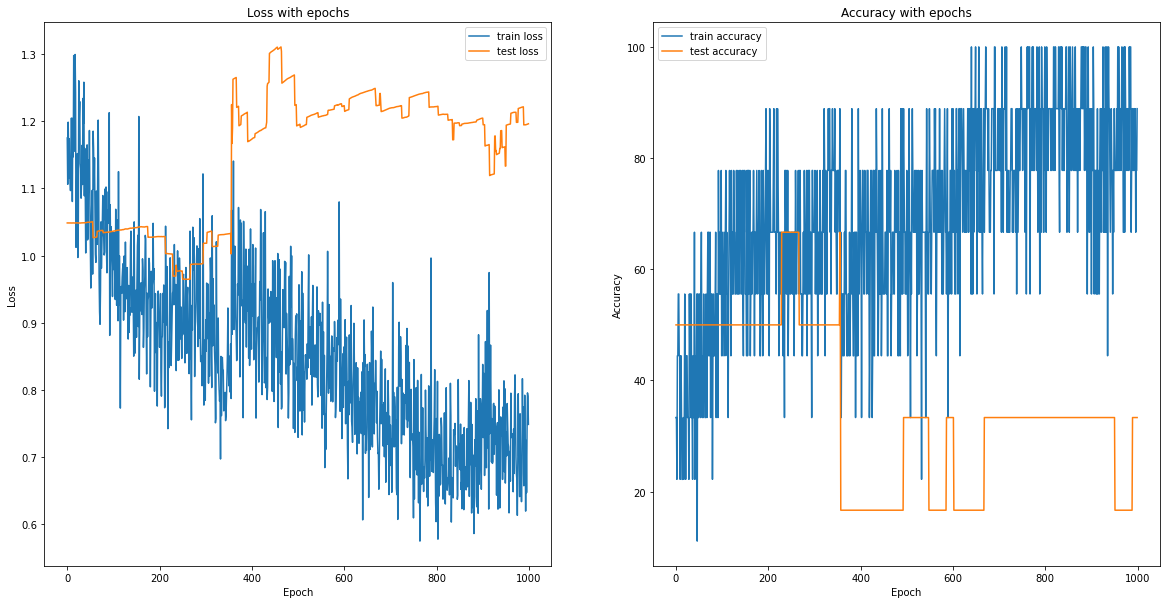

In [20]:
#Plotting of the loss
x_plot = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(x_plot, train_loss, label = 'train loss')
ax[0].plot(x_plot, valid_loss, label = 'test loss')
ax[0].set_title('Loss with epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(x_plot, train_accuracy, label = 'train accuracy')
ax[1].plot(x_plot, valid_accuracy, label = 'test accuracy')
ax[1].set_title('Accuracy with epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

## Make it run across all experiments

In [59]:
path = r'C:\Users\harol\UsefulCode\CP_DSAI\Project\Dataset\SEED\ExtractedFeatures'
signals = 'de'
use_freq = 0
smoothing_method = 'movingAve'
labels = labels

In [60]:
order_K = 15
learning_rate = 0.00001
alpha = 0.0005 #regularization parameter
num_epochs = 1000

In [62]:
glob_train_loss = []
glob_test_loss = []
glob_train_acc = []
glob_test_acc = []


for sub in range(1, 16):
    subject_number = sub
    for exp in range(3):
        experiment_number = exp
        dataset = SignalDataset(path, signals, subject_number, experiment_number, labels, smoothing_method, 
                                freq = use_freq)
        train_dataset, test_dataset = random_split(dataset, [9, 6])
        batch_size = 1
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
        #matrix we will work with
        W_ = W[use_freq].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency

        #model
        model = DGCN_Cheb(W_, order_K, 62*265, 50, 3).to(device)

        #oss functions and optimizer

        criterion = nn.CrossEntropyLoss()

        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 



        #training of the model
        train_loss = []
        valid_loss = []
        train_accuracy = []
        valid_accuracy = []

        for epoch in range(num_epochs):

            ############################
            # Train
            ############################

            iter_loss = 0.0
            correct = 0
            iterations = 0

            model.train()        # Put the network into training mode

            for i, (signal, label_) in enumerate(train_loader):

                optimizer.zero_grad()     # Clear off the gradients from any past operation
                outputs = model(signal)      # Do the forward pass
                loss = criterion(outputs, label_) # Calculate the loss
                iter_loss += loss.item() # Accumulate the loss

                #L1-Regularization
                l1_norm = sum(abs(p).sum() for p in model.parameters())
                loss = loss + alpha*l1_norm
                loss.backward()           # Calculate the gradients with help of back propagation
               #print('W')
               #print(model.GCNLayer1.W)
               #print(model.GCNLayer1.W.grad)
               #print('theta')
               #print(model.GCNLayer1.theta)
               #print(model.GCNLayer1.theta.grad)
                optimizer.step()          # Adjust the parameters based on the gradients


                # Record the correct predictions for training data 
                predicted = torch.max(outputs.data, 1)[1]
                correct += (predicted == label_).sum()
                iterations += 1

            # Record the training loss
            train_loss.append(iter_loss / iterations)
            # Record the training accuracy
            train_accuracy.append((100 * correct / float(len(train_dataset))))


            ############################
            # Test
            ############################

            loss = 0.0
            correct = 0
            iterations = 0

            model.eval()                    # Put the network into evaluate mode

            for i, (signal, label_) in enumerate(test_loader):

                outputs = model(signal)      # Do the forward pass
                loss += criterion(outputs, label_).item() # Calculate the loss

                # Record the correct predictions for training data
                predicted = torch.max(outputs.data, 1)[1]
                correct += (predicted == label_).sum()

                iterations += 1

            # Record the validation loss
            valid_loss.append(loss / iterations)
            # Record the validation accuracy
            correct_scalar = np.array([correct.clone()])[0]
            valid_accuracy.append(correct_scalar.item() / len(test_dataset) * 100.0)

        glob_train_loss.append(train_loss)
        glob_test_loss.append(valid_loss)
        glob_train_acc.append(train_accuracy)
        glob_test_acc.append(valid_accuracy)

label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat
label.mat


KeyboardInterrupt: 

(41, 1000) (41, 1000) (41, 1000) (41, 1000)
------- Best validation accuracy got -----------
The best validation accuracy got is 83.33333333333334 for the experiment 1 of the subject 9 at the epoch 402

------ Best validation accuracy got for each experiment ----------
                                     
subject: 1, experiment: 1   50.000000
subject: 1, experiment: 2   33.333333
subject: 1, experiment: 3   33.333333
subject: 2, experiment: 1   33.333333
subject: 2, experiment: 2   66.666667
subject: 2, experiment: 3   33.333333
subject: 3, experiment: 1   66.666667
subject: 3, experiment: 2   50.000000
subject: 3, experiment: 3   33.333333
subject: 4, experiment: 1   66.666667
subject: 4, experiment: 2   66.666667
subject: 4, experiment: 3   16.666667
subject: 5, experiment: 1   33.333333
subject: 5, experiment: 2   33.333333
subject: 5, experiment: 3   16.666667
subject: 6, experiment: 1   33.333333
subject: 6, experiment: 2   50.000000
subject: 6, experiment: 3   50.000000
subject:

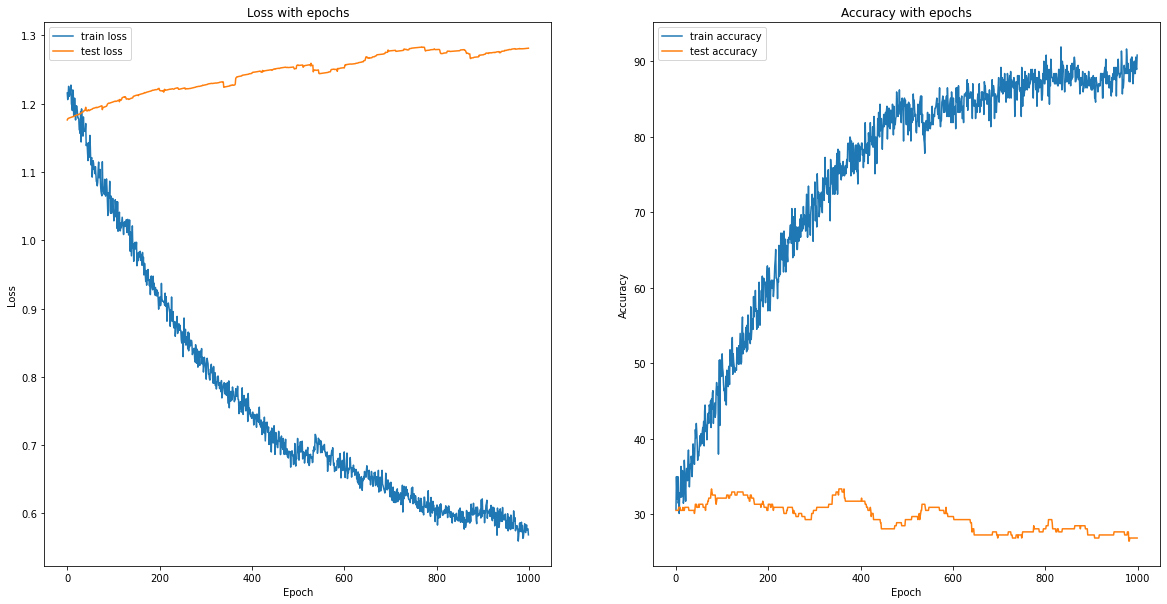

In [83]:
#plotting part

glob_train_loss = np.array(glob_train_loss)
glob_test_loss = np.array(glob_test_loss)
glob_train_acc = np.array(glob_train_acc)
glob_test_acc = np.array(glob_test_acc)
print(glob_train_loss.shape, glob_test_loss.shape, glob_train_acc.shape, glob_test_acc.shape)

mean_glob_train_loss = np.mean(glob_train_loss, axis = 0)
mean_glob_test_loss = np.mean(glob_test_loss, axis = 0)
mean_glob_train_acc = np.mean(glob_train_acc, axis = 0)
mean_glob_test_acc = np.mean(glob_test_acc, axis = 0)

print('------- Best validation accuracy got -----------')
best_val_acc_value = np.max(np.array(glob_test_acc[0]))
best_val_acc_epoch = np.argmax(np.array(glob_test_acc[0]))
best_val_acc_subexp = 0
for k in range(1, len(glob_test_acc)):
    aux = np.max(np.array(glob_test_acc[k]))
    if aux > best_val_acc_value :
        best_val_acc_value = aux
        best_val_acc_epoch = np.argmax(glob_test_acc[k])
        best_val_acc_subexp = k
print('The best validation accuracy got is {} for the experiment {} of the subject {} at the epoch {}'.format(best_val_acc_value, (best_val_acc_subexp  % 3) + 1, (best_val_acc_subexp  // 3) + 1, best_val_acc_epoch ))
print('')

print('------ Best validation accuracy got for each experiment ----------')
pd_idx = []
for sub in range(1, 16):
    for exp in range(1, 4):
        pd_idx.append('subject: ' + str(sub) + ', experiment: ' + str(exp))
df_m = pd.DataFrame(np.max(glob_test_acc, axis = 1), index = pd_idx[:41], columns = [''])
print(df_m)
print('')

print('------ Mean of the validation accuracy for the last 50 epochs-----------')
df_mean = pd.DataFrame(np.mean(glob_test_acc[:, 950:], axis = 1).reshape(-1, 1), index = pd_idx[:41], columns = [''])
print(df_mean)

x_plot = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(x_plot, mean_glob_train_loss, label = 'train loss')
ax[0].plot(x_plot, mean_glob_test_loss, label = 'test loss')
ax[0].set_title('Loss with epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(x_plot, mean_glob_train_acc, label = 'train accuracy')
ax[1].plot(x_plot, mean_glob_test_acc, label = 'test accuracy')
ax[1].set_title('Accuracy with epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

In [14]:
def train_model(model, num_epochs, train_loader, test_loader, optimizer, loss_function, alpha):

    #training of the model
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []

    for epoch in range(num_epochs):

        ############################
        # Train
        ############################

        iter_loss = 0.0
        correct = 0
        iterations = 0

        model.train()        # Put the network into training mode

        for i, (signal, label_) in enumerate(train_loader):

            optimizer.zero_grad()     # Clear off the gradients from any past operation
            outputs = model(signal)      # Do the forward pass
            loss = criterion(outputs, label_) # Calculate the loss
            iter_loss += loss.item() # Accumulate the loss

            #L1-Regularization
            l1_norm = sum(abs(p).sum() for p in model.parameters())
            loss = loss + alpha*l1_norm
            loss.backward()           # Calculate the gradients with help of back propagation
           #print('W')
           #print(model.GCNLayer1.W)
           #print(model.GCNLayer1.W.grad)
           #print('theta')
           #print(model.GCNLayer1.theta)
           #print(model.GCNLayer1.theta.grad)
            optimizer.step()          # Adjust the parameters based on the gradients


            # Record the correct predictions for training data 
            predicted = torch.max(outputs.data, 1)[1]
            correct += (predicted == label_).sum()
            iterations += 1

        # Record the training loss
        train_loss.append(iter_loss / iterations)
        # Record the training accuracy
        train_accuracy.append((100 * correct / float(len(train_dataset))))


        ############################
        # Test
        ############################

        loss = 0.0
        correct = 0
        iterations = 0

        model.eval()                    # Put the network into evaluate mode

        for i, (signal, label_) in enumerate(test_loader):

            outputs = model(signal)      # Do the forward pass
            loss += criterion(outputs, label_).item() # Calculate the loss

            # Record the correct predictions for training data
            predicted = torch.max(outputs.data, 1)[1]
            correct += (predicted == label_).sum()

            iterations += 1

        # Record the validation loss
        valid_loss.append(loss / iterations)
        # Record the validation accuracy
        correct_scalar = np.array([correct.clone()])[0]
        valid_accuracy.append(correct_scalar.item() / len(test_dataset) * 100.0)
        
    return train_loss, valid_loss, train_accuracy, valid_accuracy

## Find the optimal combination learning rate, regularization parameter

In [15]:
import time

In [94]:
learningrate_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 0] #0 to check the impact of the l1-regularization

def create_grid_search(l1, l2):
    l = []
    for element1 in l1:
        for element2 in l2:
            l.append((element1, element2))
    return l

grid_search = create_grid_search(learningrate_list, alpha_list)
print(grid_search)
num_epochs = 1000

experiment_res_train_loss = []
experiment_res_test_loss = []
experiment_res_train_acc = []
experiment_res_test_acc = []

for (lr_, alph_) in grid_search:
    
    W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency
    
    model = DGCN_Cheb(W_, 15, 62*265, 50, 3).to(device)
    
    #hyperparameters, loss functions and optimizer

    learning_rate = lr_
    alpha = alph_


    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 
    
    train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, num_epochs, 
                                                                train_loader, test_loader, optimizer, 
                                                                         criterion, alpha)
    experiment_res_train_loss.append(train_loss)
    experiment_res_test_loss.append(valid_loss)
    experiment_res_train_acc.append(train_accuracy)
    experiment_res_test_acc.append(valid_accuracy)


[(1e-07, 1e-07), (1e-07, 1e-06), (1e-07, 1e-05), (1e-07, 0.0001), (1e-07, 0.001), (1e-07, 0), (1e-06, 1e-07), (1e-06, 1e-06), (1e-06, 1e-05), (1e-06, 0.0001), (1e-06, 0.001), (1e-06, 0), (1e-05, 1e-07), (1e-05, 1e-06), (1e-05, 1e-05), (1e-05, 0.0001), (1e-05, 0.001), (1e-05, 0), (0.0001, 1e-07), (0.0001, 1e-06), (0.0001, 1e-05), (0.0001, 0.0001), (0.0001, 0.001), (0.0001, 0), (0.001, 1e-07), (0.001, 1e-06), (0.001, 1e-05), (0.001, 0.0001), (0.001, 0.001), (0.001, 0)]


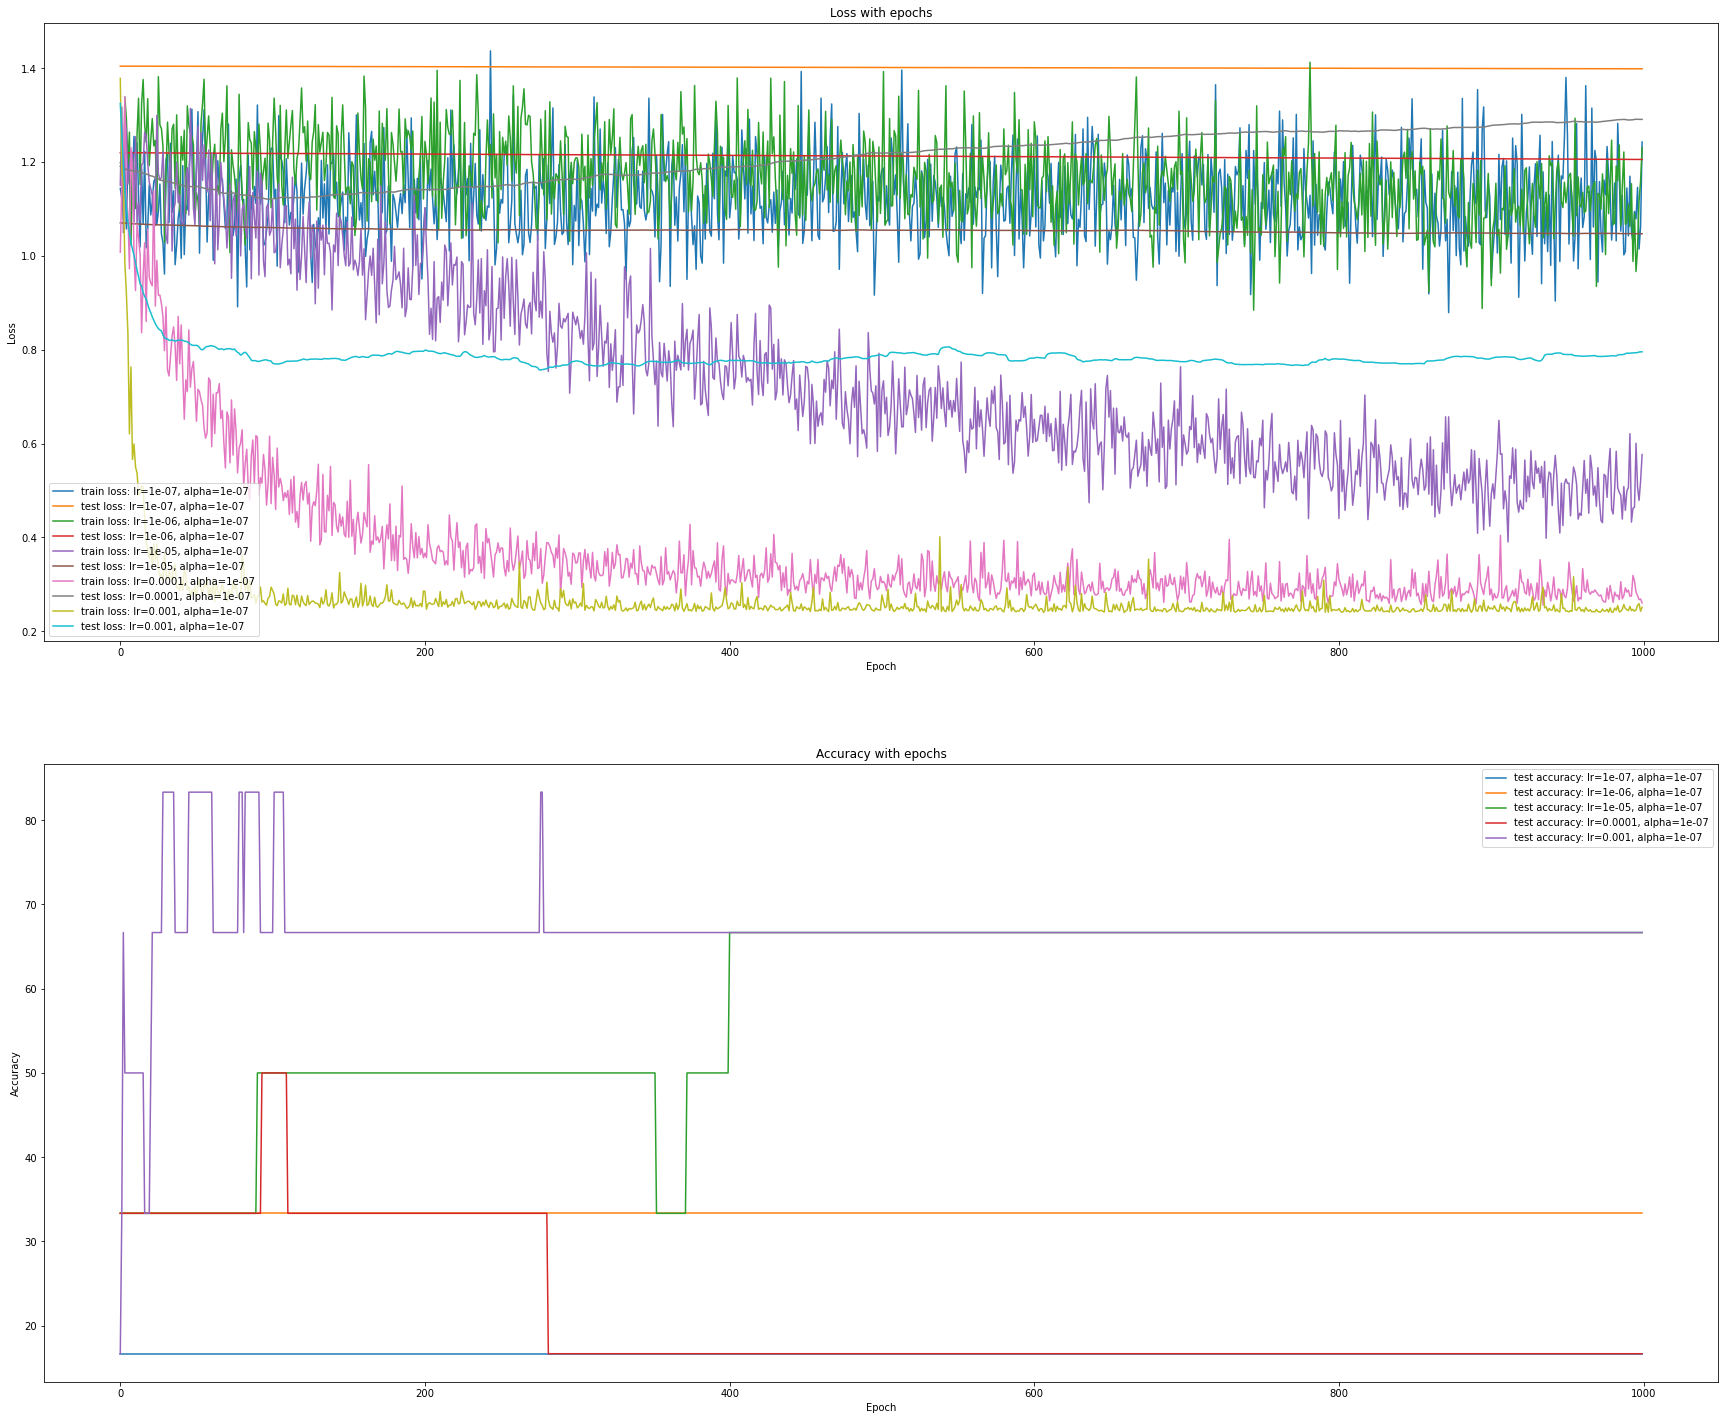

In [109]:
x_plot = np.arange(num_epochs)
fig, ax = plt.subplots(2, 1, figsize=(30, 25))

for k in range(0, len(experiment_res_train_loss), 6):
    ax[0].plot(x_plot, experiment_res_train_loss[k], label = 'train loss: lr={}, alpha={}'.format(grid_search[k][0], grid_search[k][1]))
    ax[0].plot(x_plot, experiment_res_test_loss[k], label = 'test loss: lr={}, alpha={}'.format(grid_search[k][0], grid_search[k][1]))
    #ax[1].plot(x_plot, experiment_res_train_acc[k], label = 'train accuracy: lr={}, alpha={}'.format(grid_search[k][0], grid_search[k][1]))
    ax[1].plot(x_plot, experiment_res_test_acc[k], label = 'test accuracy: lr={}, alpha={}'.format(grid_search[k][0], grid_search[k][1]))
    
ax[0].set_title('Loss with epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].set_title('Accuracy with epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

In [ ]:
x_plot = np.arange(num_epochs)
fig, ax = plt.subplots(2, 1, figsize=(30, 25))

for k in range(0, len(experiment_res_train_loss), 6):
    ax[0].plot(x_plot, experiment_res_train_loss[k], label = 'train loss: lr={}, alpha={}'.format(grid_search[k][0], grid_search[k][1]))
    ax[0].plot(x_plot, experiment_res_test_loss[k], label = 'test loss: lr={}, alpha={}'.format(grid_search[k][0], grid_search[k][1]))
    #ax[1].plot(x_plot, experiment_res_train_acc[k], label = 'train accuracy: lr={}, alpha={}'.format(grid_search[k][0], grid_search[k][1]))
    ax[1].plot(x_plot, experiment_res_test_acc[k], label = 'test accuracy: lr={}, alpha={}'.format(grid_search[k][0], grid_search[k][1]))
    
ax[0].set_title('Loss with epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].set_title('Accuracy with epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

## Impact of K on the model

In [16]:
best_learning_rate = 0.0001
alpha_optimal = 1e-7

In [72]:
num_epochs = 1000
learning_rate = best_learning_rate
alpha = alpha_optimal

exp_K_train_loss = []
exp_K_test_loss = []
exp_K_train_acc = []
exp_K_test_acc = []

KK = [1, 5, 10, 15, 20]

for K in KK:
    
    W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency
    
    model = DGCN_Cheb(W_, K, 62*265, 50, 3).to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 
    
    train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, num_epochs, 
                                                                train_loader, test_loader, optimizer, 
                                                                         criterion, alpha)
    exp_K_train_loss.append(train_loss)
    exp_K_test_loss.append(valid_loss)
    exp_K_train_acc.append(train_accuracy)
    exp_K_test_acc.append(valid_accuracy)

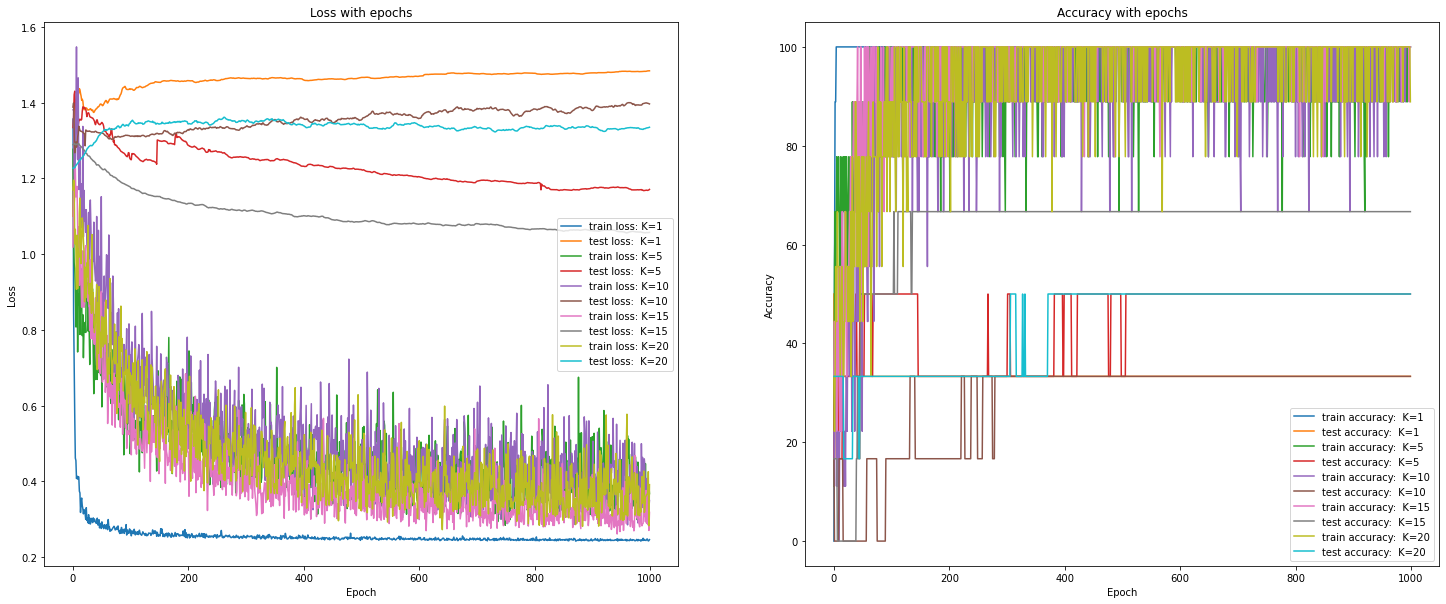

In [74]:
x_plot = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(25, 10))


for k in range(len(KK)):
    ax[0].plot(x_plot, exp_K_train_loss[k], label = 'train loss: K={}'.format(KK[k]))
    ax[0].plot(x_plot, exp_K_test_loss[k], label = 'test loss:  K={}'.format(KK[k]))
    ax[1].plot(x_plot, exp_K_train_acc[k], label = 'train accuracy:  K={}'.format(KK[k]))
    ax[1].plot(x_plot, exp_K_test_acc[k], label = 'test accuracy:  K={}'.format(KK[k]))

ax[0].set_title('Loss with epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].set_title('Accuracy with epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

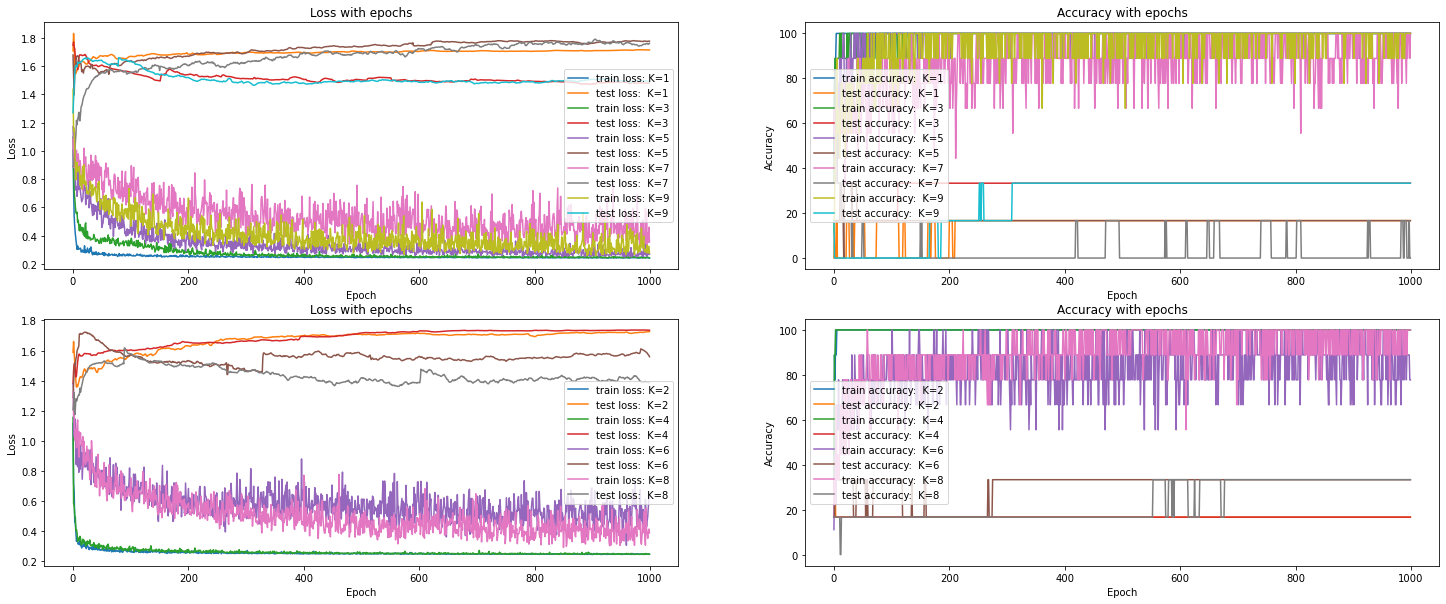

In [37]:
x_plot = np.arange(num_epochs)
fig, ax = plt.subplots(2, 2, figsize=(25, 10))


for k in range(0, 10, 2):
    ax[0][0].plot(x_plot, exp_K_train_loss[k], label = 'train loss: K={}'.format(KK[k]))
    ax[0][0].plot(x_plot, exp_K_test_loss[k], label = 'test loss:  K={}'.format(KK[k]))
    ax[0][1].plot(x_plot, exp_K_train_acc[k], label = 'train accuracy:  K={}'.format(KK[k]))
    ax[0][1].plot(x_plot, exp_K_test_acc[k], label = 'test accuracy:  K={}'.format(KK[k]))
    
for k in range(1, 9, 2):
    ax[1][0].plot(x_plot, exp_K_train_loss[k], label = 'train loss: K={}'.format(KK[k]))
    ax[1][0].plot(x_plot, exp_K_test_loss[k], label = 'test loss:  K={}'.format(KK[k]))
    ax[1][1].plot(x_plot, exp_K_train_acc[k], label = 'train accuracy:  K={}'.format(KK[k]))
    ax[1][1].plot(x_plot, exp_K_test_acc[k], label = 'test accuracy:  K={}'.format(KK[k]))   
    
ax[0][0].set_title('Loss with epochs')
ax[0][0].set_xlabel('Epoch')
ax[0][0].set_ylabel('Loss')
ax[0][0].legend()
ax[0][1].set_title('Accuracy with epochs')
ax[0][1].set_xlabel('Epoch')
ax[0][1].set_ylabel('Accuracy')
ax[0][1].legend()
ax[1][0].set_title('Loss with epochs')
ax[1][0].set_xlabel('Epoch')
ax[1][0].set_ylabel('Loss')
ax[1][0].legend()
ax[1][1].set_title('Accuracy with epochs')
ax[1][1].set_xlabel('Epoch')
ax[1][1].set_ylabel('Accuracy')
ax[1][1].legend()

plt.show()

## Choose best optimizer

In [41]:
optimal_K = 9

In [42]:
num_epochs = 1000
learning_rate = best_learning_rate
alpha = alpha_optimal
K = optimal_K

exp_opt_train_loss = []
exp_opt_test_loss = []
exp_opt_train_acc = []
exp_opt_test_acc = []

    
W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency

model = DGCN_Cheb(W_, K, 62*265, 50, 3).to(device)

#hyperparameters, loss functions and optimizer

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 

train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, num_epochs, 
                                                            train_loader, test_loader, optimizer, 
                                                                     criterion, alpha)
exp_opt_train_loss.append(train_loss)
exp_opt_test_loss.append(valid_loss)
exp_opt_train_acc.append(train_accuracy)
exp_opt_test_acc.append(valid_accuracy)



W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency

model = DGCN_Cheb(W_, K, 62*265, 50, 3).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, num_epochs, 
                                                            train_loader, test_loader, optimizer, 
                                                                     criterion, alpha)
exp_opt_train_loss.append(train_loss)
exp_opt_test_loss.append(valid_loss)
exp_opt_train_acc.append(train_accuracy)
exp_opt_test_acc.append(valid_accuracy)


W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency

model = DGCN_Cheb(W_, K, 62*265, 50, 3).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate) 

train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, num_epochs, 
                                                            train_loader, test_loader, optimizer, 
                                                                     criterion, alpha)
exp_opt_train_loss.append(train_loss)
exp_opt_test_loss.append(valid_loss)
exp_opt_train_acc.append(train_accuracy)
exp_opt_test_acc.append(valid_accuracy)

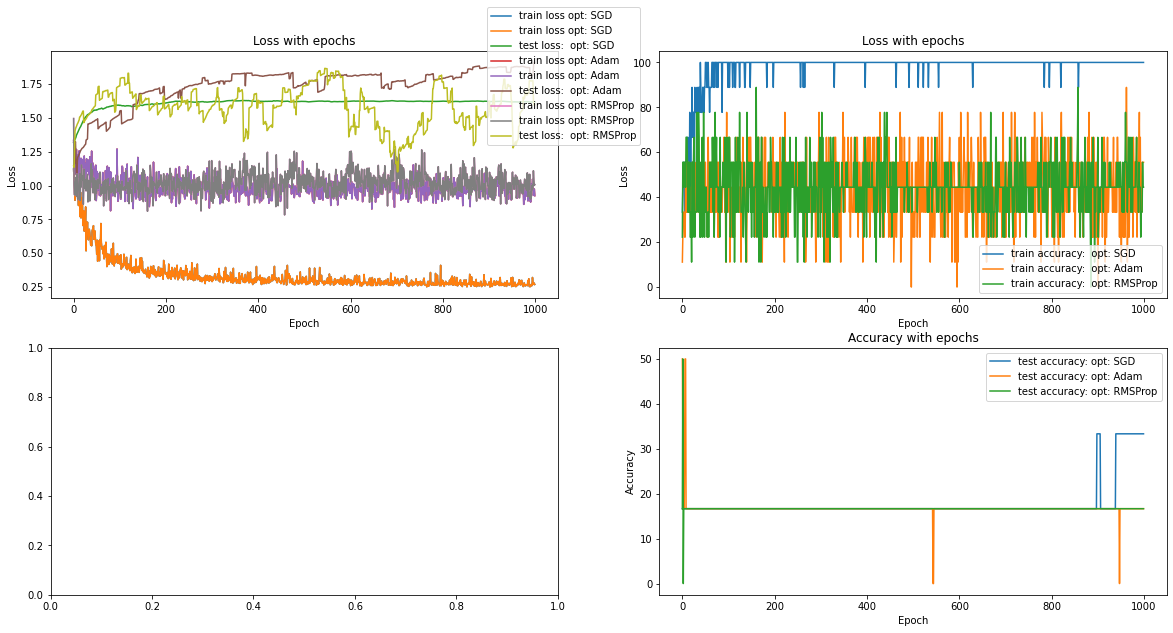

In [56]:
x_plot = np.arange(num_epochs)
fig, ax = plt.subplots(2, 2, figsize=(20, 10))


opt_list = ['SGD', 'Adam', 'RMSProp']
for k in range(3):
    ax[0][0].plot(x_plot, exp_opt_train_loss[k], label = 'train loss opt: {}'.format(opt_list[k]))
    ax[0][0].plot(x_plot, exp_opt_train_loss[k], label = 'train loss opt: {}'.format(opt_list[k]))
    ax[0][0].plot(x_plot, exp_opt_test_loss[k], label = 'test loss:  opt: {}'.format(opt_list[k]))
    ax[0][1].plot(x_plot, exp_opt_train_acc[k], label = 'train accuracy:  opt: {}'.format(opt_list[k]))
    ax[1][1].plot(x_plot, exp_opt_test_acc[k], label = 'test accuracy: opt: {}'.format(opt_list[k]))
    
ax[0][0].set_title('Loss with epochs')
ax[0][0].set_xlabel('Epoch')
ax[0][0].set_ylabel('Loss')
ax[0][0].legend(bbox_to_anchor = ((0.85, 0.6)))

ax[0][1].set_title('Loss with epochs')
ax[0][1].set_xlabel('Epoch')
ax[0][1].set_ylabel('Loss')
ax[0][1].legend()

ax[1][1].set_title('Accuracy with epochs')
ax[1][1].set_xlabel('Epoch')
ax[1][1].set_ylabel('Accuracy')
ax[1][1].legend()
plt.show()

## Impact of the regularization

The value of alpha has maybe to be change due to the change of the regularization

In [44]:
def train_model2(model, num_epochs, train_loader, test_loader, optimizer, loss_function, alpha):

    #training of the model
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []

    for epoch in range(num_epochs):
        t1 = time.time()

        ############################
        # Train
        ############################

        iter_loss = 0.0
        correct = 0
        iterations = 0

        model.train()        # Put the network into training mode

        for i, (signal, label_) in enumerate(train_loader):

            optimizer.zero_grad()     # Clear off the gradients from any past operation
            outputs = model(signal)      # Do the forward pass
            loss = criterion(outputs, label_) # Calculate the loss
            iter_loss += loss.item() # Accumulate the loss

            #L2-Regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + alpha*l2_norm
            loss.backward()           # Calculate the gradients with help of back propagation
           #print('W')
           #print(model.GCNLayer1.W)
           #print(model.GCNLayer1.W.grad)
           #print('theta')
           #print(model.GCNLayer1.theta)
           #print(model.GCNLayer1.theta.grad)
            optimizer.step()          # Adjust the parameters based on the gradients


            # Record the correct predictions for training data 
            predicted = torch.max(outputs.data, 1)[1]
            correct += (predicted == label_).sum()
            iterations += 1

        # Record the training loss
        train_loss.append(iter_loss / iterations)
        # Record the training accuracy
        train_accuracy.append((100 * correct / float(len(train_dataset))))


        ############################
        # Test
        ############################

        loss = 0.0
        correct = 0
        iterations = 0

        model.eval()                    # Put the network into evaluate mode

        for i, (signal, label_) in enumerate(test_loader):

            outputs = model(signal)      # Do the forward pass
            loss += criterion(outputs, label_).item() # Calculate the loss

            # Record the correct predictions for training data
            predicted = torch.max(outputs.data, 1)[1]
            correct += (predicted == label_).sum()

            iterations += 1

        # Record the validation loss
        valid_loss.append(loss / iterations)
        # Record the validation accuracy
        correct_scalar = np.array([correct.clone()])[0]
        valid_accuracy.append(correct_scalar.item() / len(test_dataset) * 100.0)
        
    return train_loss, valid_loss, train_accuracy, valid_accuracy

In [45]:
num_epochs = 1000
learning_rate = best_learning_rate
alpha = alpha_optimal
K = optimal_K

exp_reg_train_loss = []
exp_reg_test_loss = []
exp_reg_train_acc = []
exp_reg_test_acc = []

W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency

model = DGCN_Cheb(W_, K, 62*265, 50, 3).to(device)

#hyperparameters, loss functions and optimizer

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 

train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, num_epochs, 
                                                            train_loader, test_loader, optimizer, 
                                                                     criterion, alpha)
exp_reg_train_loss.append(train_loss)
exp_reg_test_loss.append(valid_loss)
exp_reg_train_acc.append(train_accuracy)
exp_reg_test_acc.append(valid_accuracy)

W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency
model = DGCN_Cheb(W_, K, 62*265, 50, 3).to(device)
#hyperparameters, loss functions and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 
train_loss, valid_loss, train_accuracy, valid_accuracy = train_model2(model, num_epochs, 
                                                            train_loader, test_loader, optimizer, 
                                                                     criterion, alpha)
exp_reg_train_loss.append(train_loss)
exp_reg_test_loss.append(valid_loss)
exp_reg_train_acc.append(train_accuracy)
exp_reg_test_acc.append(valid_accuracy)

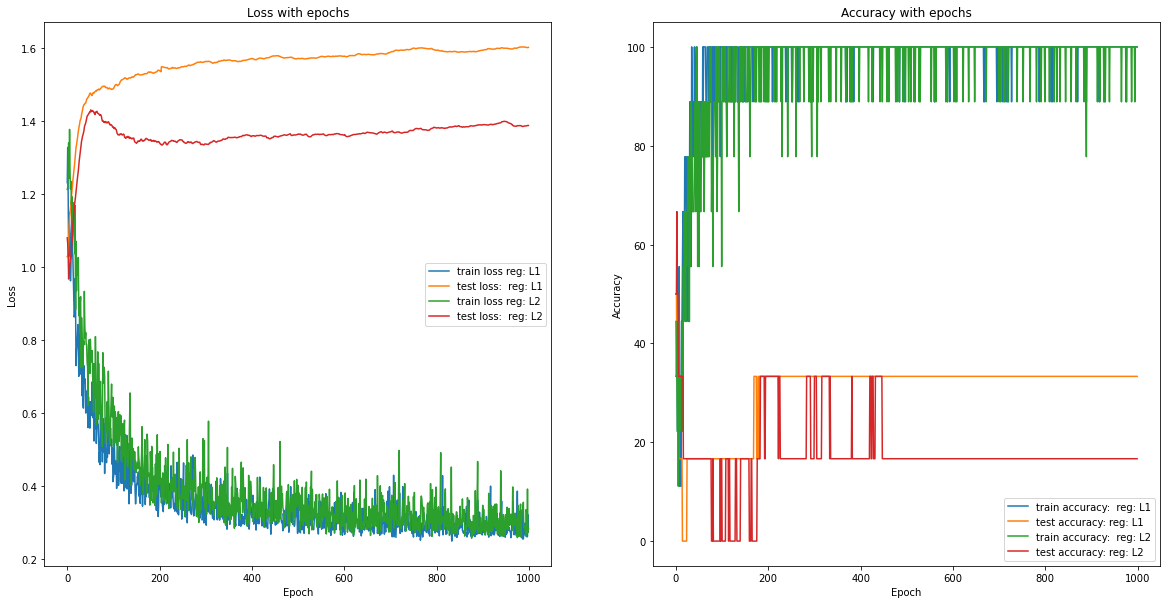

In [46]:
x_plot = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

reg_list = ['L1', 'L2']
for k in range(2):
    ax[0].plot(x_plot, exp_reg_train_loss[k], label = 'train loss reg: {}'.format(reg_list[k]))
    ax[0].plot(x_plot, exp_reg_test_loss[k], label = 'test loss:  reg: {}'.format(reg_list[k]))
    ax[1].plot(x_plot, exp_reg_train_acc[k], label = 'train accuracy:  reg: {}'.format(reg_list[k]))
    ax[1].plot(x_plot, exp_reg_test_acc[k], label = 'test accuracy: reg: {}'.format(reg_list[k]))
    
ax[0].set_title('Loss with epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].set_title('Accuracy with epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

## Check if difference with the smoothing method

In [63]:
learning_rate = 0.0001
alph = 1e-7

In [70]:
exp_smooth_train_loss = []
exp_smooth_test_loss = []
exp_smooth_train_acc = []
exp_smooth_test_acc = []

num_epochs = 1000
learning_rate = best_learning_rate
alpha = alpha_optimal
K = optimal_K

subject_number = 9 #arbitrary
experiment_number = 0 #arbitrary
smoothing_method = 'movingAve'
dataset = SignalDataset(path, signals, subject_number, experiment_number, labels, smoothing_method, 
                                freq = 0)
train_dataset, test_dataset = random_split(dataset, [9, 6])
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)


W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency

model = DGCN_Cheb(W_, K, 62*265, 50, 3).to(device)

#hyperparameters, loss functions and optimizer

learning_rate = lr
alpha = alph

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 

train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, num_epochs, 
                                                            train_loader, test_loader, optimizer, 
                                                                     criterion, alpha)
exp_smooth_train_loss.append(train_loss)
exp_smooth_test_loss.append(valid_loss)
exp_smooth_train_acc.append(train_accuracy)
exp_smooth_test_acc.append(valid_accuracy)



subject_number = 9 #arbitrary
experiment_number = 0 #arbitrary
smoothing_method = 'LDS'
dataset = SignalDataset(path, signals, subject_number, experiment_number, labels, smoothing_method = 'LDS', 
                                freq = 0)
train_dataset, test_dataset = random_split(dataset, [9, 6])
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)


W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency

model = DGCN_Cheb(W_, K, 62*265, 50, 3).to(device)

#hyperparameters, loss functions and optimizer

learning_rate = lr
alpha = alph

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 

train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, num_epochs, 
                                                            train_loader, test_loader, optimizer, 
                                                                     criterion, alpha)
exp_smooth_train_loss.append(train_loss)
exp_smooth_test_loss.append(valid_loss)
exp_smooth_train_acc.append(train_accuracy)
exp_smooth_test_acc.append(valid_accuracy)

label.mat
label.mat


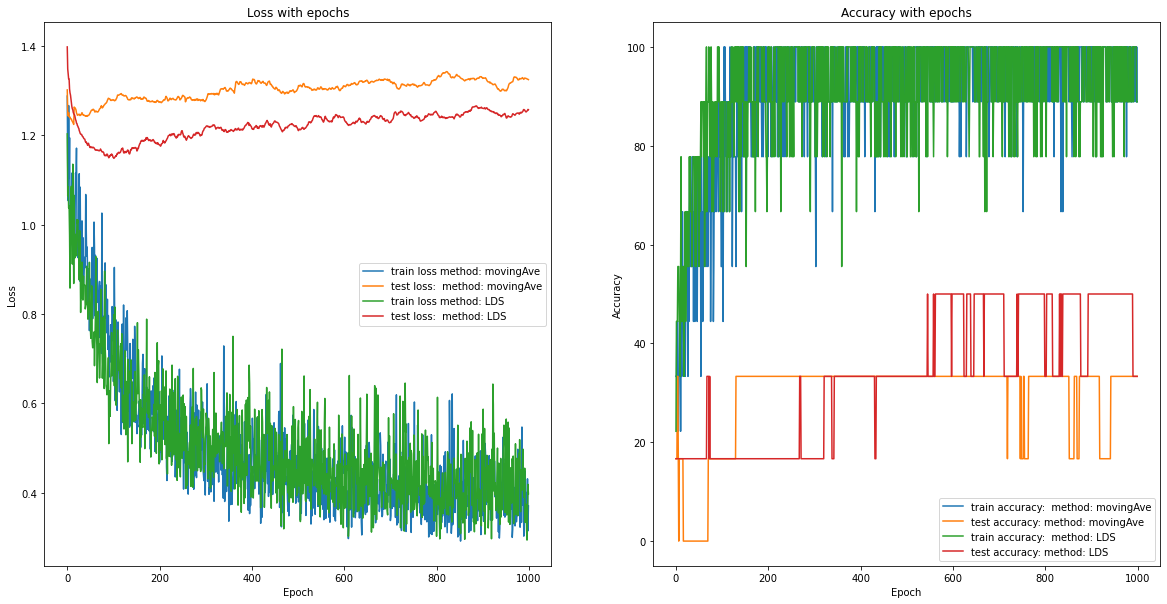

In [71]:
###MAKE THE PLOTTING#######
x_plot = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

smooth_list = ['movingAve', 'LDS']
for k in range(2):
    ax[0].plot(x_plot, exp_smooth_train_loss[k], label = 'train loss method: {}'.format(smooth_list[k]))
    ax[0].plot(x_plot, exp_smooth_test_loss[k], label = 'test loss:  method: {}'.format(smooth_list[k]))
    ax[1].plot(x_plot, exp_smooth_train_acc[k], label = 'train accuracy:  method: {}'.format(smooth_list[k]))
    ax[1].plot(x_plot, exp_smooth_test_acc[k], label = 'test accuracy: method: {}'.format(smooth_list[k]))
    
ax[0].set_title('Loss with epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].set_title('Accuracy with epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()


## Time of training 

In [114]:
import time

time_exec = np.zeros(10)

num_epochs = 1000
learning_rate = 0.001
alpha = 1e-7

exp_time_train_loss = []
exp_time_test_loss = []
exp_time_train_acc = []
exp_time_test_acc = []

K = 12

for k in range(10):
    
    W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency

    model = DGCN_Cheb(W_, K, 62*265, 50, 3).to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 
    
    t1 = time.time()

    train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, num_epochs, 
                                                                train_loader, test_loader, optimizer, 
                                                                         criterion, alpha)
    
    t2 = time.time()
    time_exec[k] = t2 - t1
    
    exp_time_train_loss.append(train_loss)
    exp_time_test_loss.append(valid_loss)
    exp_time_train_acc.append(train_accuracy)
    exp_time_test_acc.append(valid_accuracy)
    
print(np.mean(time_exec))

1942.2397305727004


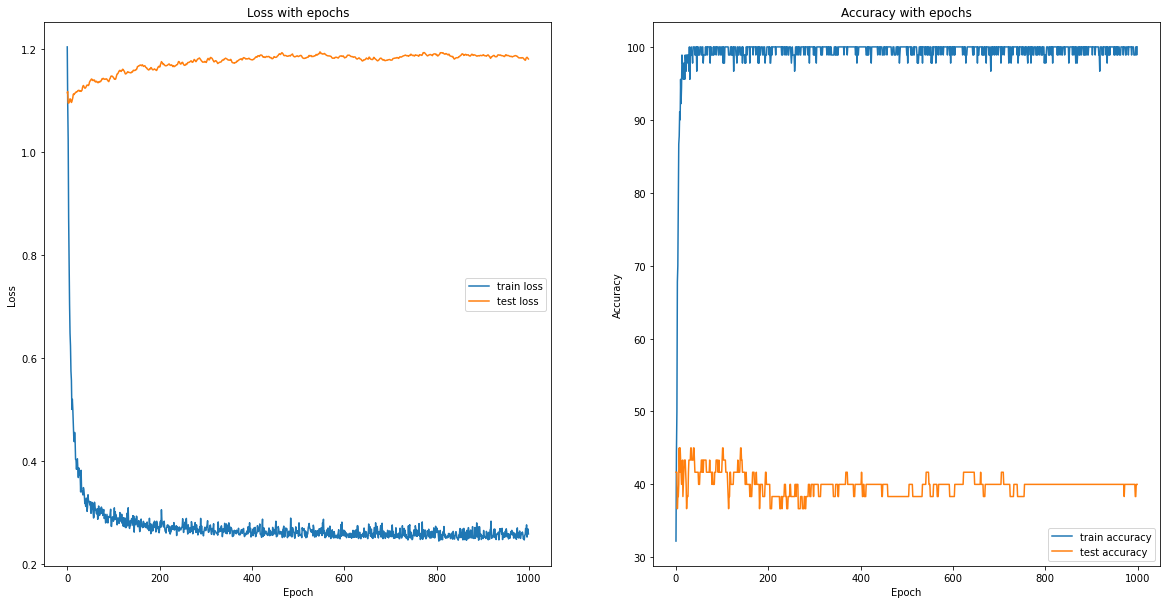

In [115]:
exp_time_train_loss = np.array(exp_time_train_loss)
exp_time_test_loss = np.array(exp_time_test_loss)
exp_time_train_acc = np.array(exp_time_train_acc)
exp_time_test_acc = np.array(exp_time_test_acc)

mean_exp_time_train_loss = np.mean(exp_time_train_loss, axis = 0)
mean_exp_time_test_loss = np.mean(exp_time_test_loss, axis = 0)
mean_exp_time_train_acc = np.mean(exp_time_train_acc, axis = 0)
mean_exp_time_test_acc = np.mean(exp_time_test_acc, axis = 0)

x_plot = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(x_plot, mean_exp_time_train_loss, label = 'train loss')
ax[0].plot(x_plot, mean_exp_time_test_loss, label = 'test loss')
ax[1].plot(x_plot, mean_exp_time_train_acc, label = 'train accuracy')
ax[1].plot(x_plot, mean_exp_time_test_acc, label = 'test accuracy')
    
ax[0].set_title('Loss with epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].set_title('Accuracy with epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()
